In [4]:
import os
# from recipes import surfacespeed
from importlib import reload
# from ttidelib import logmsg
import shutil
import subprocess
import dask
import xarray as xr
from matplotlib import pyplot as plt
from dask.distributed import Client, default_client
from pathlib import Path
import sys
os.chdir('/home/149/ab8992/tasman-tides')

import ttidelib as tt

Some of the postprocessed data have nans along one or more of the cross beam segments! Need to iterate through all the chunks and see

In [7]:
import glob
import numpy as np
def check_outputs(expt,rerun = True):
    print(expt,end = "\n\n")
    if "40" in expt:
        no = 34    
    elif "10" in expt:
        no = 10
    else:
        no = 17

    dirs = os.listdir(f"/g/data/nm03/ab8992/outputs/{expt}")
    vars = ["ahh","v","u","rho"]
    # tell me how many files in each directory
    # print(dirs)
    for dir in dirs:
        if dir[0] != "o":
            continue
        print(dir,end = "\t")
        bad = False
        for var in vars:
            # print(len(os.listdir(f"/g/data/nm03/ab8992/outputs/{expt}/" + dir + "/" + var)))
            if not os.path.exists(f"/g/data/nm03/ab8992/outputs/{expt}/" + dir + "/" + var):

                bad = True
            files = glob.glob(f"/g/data/nm03/ab8992/outputs/{expt}/" + dir + "/" + var + "/*.nc")
            if os.path.exists(f"/g/data/nm03/ab8992/outputs/{expt}/" + dir + "/" + var) and len(files) != no:
                
                bad = True
            
            ## Now check for NaNs in the middle of the domain
            z = "zl"
            if var == "e":
                z = "rho2_i"
            for file in files:
                val = xr.open_dataset(
                    str(file),decode_cf = False,decode_times = False
                ).sel(xb = 1000,method = "nearest").isel({"time": 0,z: 0,"yb":0})[var].values
                # print(val,type(val))
                if np.isnan(val):
                    bad = True
                    print("\t" + file)
                if np.abs(val) - 0.0 < 1e-10:
                    bad = True
                    print("\tBAD!" + file,val)
            print(var,end = "\t")

                
        if bad:
            print("\t" + dir,end = "\n")
            if rerun:
                subprocess.run(
                        f"python3 recipes.py -r postprocess -e {expt} -o {int(dir.split('output')[-1])} & ",
                        shell=True,
                        text=True,
                        cwd = f"/home/149/ab8992/tasman-tides",
                        )
        print()
    print()

# check("notide-40")
# print("full-20")
# check("full-20")
# print()
# print("notide-20")
# check("notide-20")
# print()

check_outputs("full-20",rerun = False)



full-20

output128	ahh	v	u	rho	
output263	ahh	v	u	rho	
output095	ahh	v	u	rho	
output094	ahh	v	u	rho	
output155	ahh	v	u	rho	
output239	ahh	v	u	rho	
output164	ahh	v	u	rho	
output158	ahh	v	u	rho	
output021	ahh	v	u	rho	
output229	ahh	v	u	rho	
output082	ahh	v	u	rho	
output054	ahh	v	u	rho	
output198	ahh	v	u	rho	
output066	ahh	v	u	rho	
output242	ahh	v	u	rho	
output151	ahh	v	u	rho	
output113	ahh	v	u	rho	
output244	ahh	v	u	rho	
output122	ahh	v	u	rho	
output110	ahh	v	u	rho	
output056	ahh	v	u	rho	
output230	ahh	v	u	rho	
output014	ahh	v	u	rho	
output043	ahh	v	u	rho	
output002	ahh	v	u	rho	
output114	ahh	v	u	rho	
output237	ahh	v	u	rho	
output170	ahh	v	u	rho	
output118	ahh	v	u	rho	
output080	ahh	v	u	rho	
output015	ahh	v	u	rho	
output062	ahh	v	u	rho	
output190	ahh	v	u	rho	
output001	ahh	v	u	rho	
output249	ahh	v	u	rho	
output081	ahh	v	u	rho	
output084	ahh	v	u	rho	
output215	ahh	v	u	rho	
output083	ahh	v	u	rho	
output034	ahh	v	u	rho	
output059	ahh	v	u	rho	
output246	ahh	v	u	rho	
output107	ahh	v	u	rho	
ou

KeyboardInterrupt: 

## Looks like underlying data is ok, but when reading into lfilter something goes wrong? So we *do* seem to have a complete dataset

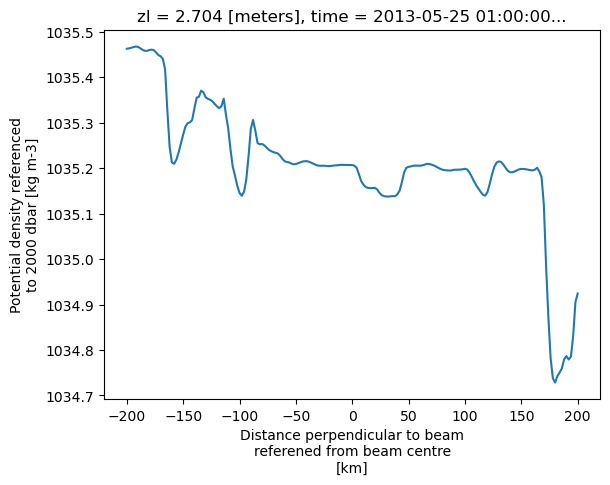

In [16]:
var = "rho"

data = xr.open_mfdataset(f"/g/data/nm03/ab8992/outputs/full-40/output035/{var}/{var}_y*.nc")
data[var].isel(time = 0,xb = 100,zl = 0).plot()

In [ ]:
## Parse the eddy times, see which ones still need running / re-running
import yaml
def check_lfiltered(expt):
    with open("EddyTimes.yml", 'r') as file:
        eddytimes = yaml.safe_load(file)[expt]

    for t0 in eddytimes["eddy"] + eddytimes["noeddy"]:
        print(t0)
        path = Path(f"/g/data/nm03/ab8992/postprocessed/{expt}/lfiltered/t0-{t0}")
        complete = True
        for i in range(10):
            if not (path / f"FastFilter{i}.nc").exists():
                print("FastFilter",i,"missing")

                complete = False

        if not complete:
            print(expt + " incomplete")
            subprocess.run(
                f"bash lfilter.sh -e {expt} -t {t0} &",
                shell=True,
                text=True,
                cwd = f"/home/149/ab8992/tasman-tides",
            )
        else:
            print(expt + " complete")


# check_lfiltered("full-20")
check_lfiltered("full-40")

FileNotFoundError: [Errno 2] No such file or directory: 'EddyTimes.yml'

# Check the spinup of each experiment

full-10   total years:  8.01
full-20   total years:  8.05
full-40   total years:  5.58
beamless-10   total years:  8.01
beamless-20   total years:  2.26
beamless-40   total years:  0.66
smooth-10   total years:  8.01
smooth-20   total years:  2.34
smooth-40   total years:  0.73


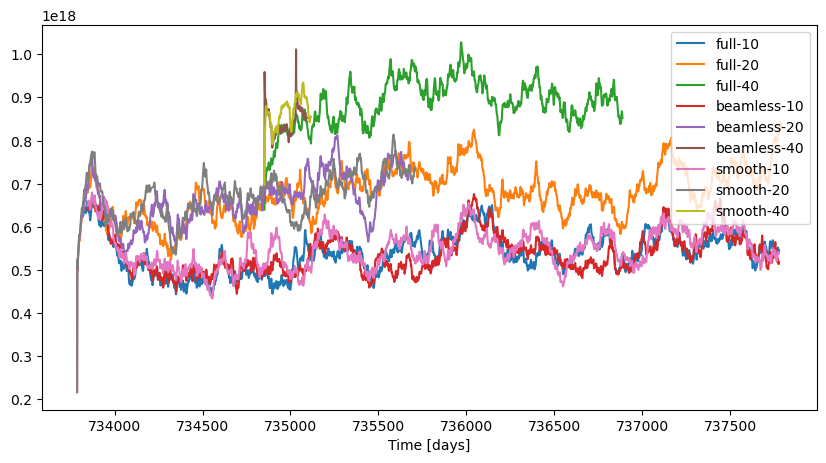

In [23]:
base = Path("/g/data/nm03/ab8992/outputs/")
fig,ax = plt.subplots(1,figsize = (10,5))
import datetime as dt
day0 = 733787
day0_40th = 734852
expts = []
for i in ["full","beamless","smooth"]:
    for j in ["10","20","40"]:
        expts.append(i + "-" + j)
for expt in expts:
    d = xr.open_mfdataset(str(base / expt / "*" / "ocean_stats.nc"),decode_times = False)

    (d.KE.sum("Layer") + d.APE.sum("Interface")).plot(ax = ax,label = expt)
    total_days = (d.Time[-1] - day0_40th).values
    print(expt,"  total years: ",round(total_days / 365,2))
    # break

ax.legend()


In [44]:
total_hours = 5 * 365 * 24
print(total_hours / 149)

293.9597315436242


In [43]:
import os
os.chdir('/home/149/ab8992/tasman-tides')
import recipes

recipes.vmodes("full-40",12666)

<Client: 'tcp://127.0.0.1:43953' processes=96 threads=96, memory=384.00 GiB>
<Client: 'tcp://127.0.0.1:43953' processes=96 threads=96, memory=384.00 GiB>
loading rho...	done.


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 19.60 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in sqrt
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in sqrt
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in sqrt
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: 

In [8]:
import xarray as xr
expts = []
for i in ["full","beamless","smooth"]:
    for j in ["10","20","40"]:
        expts.append(i + "-" + j)
import os
for expt in expts:
    with xr.open_dataset(f"/g/data/nm03/ab8992/outputs/{expt}/bathy_transect.nc") as topo:
        if "nx" in topo.dims:
            topo = topo.rename({"nx":"xb","ny":"yb"})
            print(expt)
            os.rename(
                f"/g/data/nm03/ab8992/outputs/{expt}/bathy_transect.nc",
                f"/g/data/nm03/ab8992/outputs/{expt}/bathy_transect_old.nc")
            topo.to_netcdf(f"/g/data/nm03/ab8992/outputs/{expt}/bathy_transect.nc",mode = "w")



full-40
beamless-40
smooth-40


In [37]:
13 * 17 + 12

233

In [32]:
div = 13
print(233 // div, 233 % div)
print(13 * 17 + 12)

17 12
233


In [7]:
sample_window = 400 # 48hrs advection either side of sample window
offset = 2
## If we're splitting into multiple jobs for different offsets, adjust times

for offset in range(14):
    if offset != -1:
        filter_window = 17 #! Hardcoded for 12 lots of 17 hours + 12 hours
        # sample_window = 150
        start = sample_window // 2 - 117 + offset * filter_window
        if offset == 13:
            stop -= 1
        filter_window = 12
        stop = start + filter_window


    print(start,stop)

print(316 - 83)

83 95
100 112
117 129
134 146
151 163
168 180
185 197
202 214
219 231
236 248
253 265
270 282
287 299
304 316
233


In [12]:
22000 - 17784

4216

In [13]:
4216 / 24

175.66666666666666

In [40]:
offset = 2
t0 = 1000

for offset in range(14):

    if offset != -1:
        filter_window = 17 #! Hardcoded for 9 lots of 15 hours + 14 hours
        # sample_window = 150
        t0_adjusted = t0 - 117 + offset * filter_window + filter_window // 2
        if offset == 13:
            filter_window = 12

    print(t0_adjusted,t0_adjusted + filter_window)



891 908
908 925
925 942
942 959
959 976
976 993
993 1010
1010 1027
1027 1044
1044 1061
1061 1078
1078 1095
1095 1112
1112 1124


In [41]:
print(1124 - 891)

233


In [38]:
for offset in range(10):
    if offset != -1:
        filter_window = 15 #! Hardcoded for 9 lots of 15 hours + 14 hours
        # sample_window = 150
        t0_adjusted = t0 - 75 + offset * 15 + 7
        if offset == 9:
            filter_window = 14

    print(t0_adjusted,t0_adjusted + filter_window)
    

932 947
947 962
962 977
977 992
992 1007
1007 1022
1022 1037
1037 1052
1052 1067
1067 1081


In [30]:
print(1081 - 932)

149


In [42]:
import ttidelib as tt
import xarray as xr
import numpy as np
expts = []
for i in ["full","beamless","smooth"]:
    for j in ["10","20","40"]:
        expts.append(i + "-" + j)
for expt in expts:
    ext = ""
    if "beamless" in expt:
        ext = "_noridge"
    if "smooth" in expt:
        ext = "_flattened"
    try:
        rawtopog = xr.open_dataset(f"/g/data/nm03/ab8992/ttide-inputs/full-{expt.split('-')[-1]}/bathymetry_unfinished.nc").depth
    except:
        rawtopog = xr.open_dataset(f"/g/data/nm03/ab8992/ttide-inputs/full-{expt.split('-')[-1]}/topog_raw.nc").elevation

    rawtopog = rawtopog.rename({"lat":"yh","lon":"xh"})

    topog = xr.open_dataset(f"/g/data/nm03/ab8992/ttide-inputs/full-{expt.split('-')[-1]}/topog{ext}.nc").rename({"ny":"yh","nx":"xh"}).isel(ntiles = 0)
    topog = topog.assign_coords(xh = rawtopog.xh,yh = rawtopog.yh).depth

    if "lon" in topog.coords:
        topog = topog.drop(["lon","lat"])
    topog = tt.beamgrid(topog)
    rawtopog = tt.beamgrid(rawtopog)

    topog = topog.where(~np.isnan(topog),-1 * rawtopog)

    if os.path.exists(f"/g/data/nm03/ab8992/outputs/{expt}/bathy_transect.nc"):
        os.remove(f"/g/data/nm03/ab8992/outputs/{expt}/bathy_transect.nc")
    topog.to_netcdf(f"/g/data/nm03/ab8992/outputs/{expt}/bathy_transect.nc",mode = "w")
    # rawtopog = xr.beamgrid(rawtopog)

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xesmf/frontend.py:718: UserWarning: Using dimensions ('yh', 'xh') from data variable depth as the horizontal dimensions for the regridding.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xesmf/frontend.py:718: UserWarning: Using dimensions ('yh', 'xh') from data variable depth as the horizontal dimensions for the regridding.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xesmf/frontend.py:718: UserWarning: Using dimensions ('yh', 'xh') from data variable depth as the horizontal dimensions for the regridding.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xesmf/frontend.py:718: UserWarning: Using dimensions ('yh', 'xh') from data variable elevation as the horizontal dimensions for the regridding.
  warnings.warn(
/g/data/hh5/public/apps/mini